In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
q.IBMQ.load_account() # Load account from disk
q.IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bes-qis', project='argonne')>]

In [4]:
provider = q.IBMQ.get_provider(group='bes-qis')
backend = provider.get_backend('ibmq_boeblingen')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
defaults = backend.defaults()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [5]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [6]:
def get_schedule_from_circuit(circuit):
    """
    Ignores measurements and barriers. No intelligent parallelization of schedule.
    """
    schedule = q.pulse.Schedule()

    for inst, qubits, _ in circuit.data:
        if isinstance(inst, q.extensions.Barrier) or isinstance(inst, q.circuit.Measure):
            continue

        inst_qubits = [qubit.index for qubit in qubits]
        schedule += cmd_def.get(inst.name, inst_qubits, *inst.params)

    return schedule

In [7]:
def get_qpt_schedules_and_circs(base_schedule):
    qreg = q.QuantumRegister(20)
    circ = q.QuantumCircuit(qreg)
    
    qpt_circs = q.ignis.verification.tomography.process_tomography_circuits(
        circ, prepared_qubits=[qreg[0], qreg[1]], measured_qubits=[qreg[0], qreg[1]])
    
    qpt_schedules = []
    
    for qpt_circ in qpt_circs:
        done_with_prep = False
        prep_circuit, meas_circuit = q.QuantumCircuit(), q.QuantumCircuit()

        layers = q.converters.circuit_to_dag(qpt_circ).layers()
        layer_circuits = list(map(lambda layer: qiskit.converters.dag_to_circuit(layer['graph']), layers))
        next_layer_circuit = layer_circuits.pop(0)

        while not done_with_prep:
            if next_layer_circuit.data[0][0].name == 'barrier':
                done_with_prep = True
            else:
                prep_circuit.extend(next_layer_circuit)
            next_layer_circuit = layer_circuits.pop(0)
        prep_schedule = get_schedule_from_circuit(prep_circuit.decompose())

        while True:
            if next_layer_circuit.data[0][0].name == 'barrier':
                break
            next_layer_circuit = layer_circuits.pop(0)

        for layer_circuit in layer_circuits:
            meas_circuit.extend(layer_circuit)
        meas_schedule = get_schedule_from_circuit(meas_circuit.decompose())
        meas_schedule |= cmd_def.get('measure', qubits=config.meas_map[0]) << meas_schedule.duration
        
        schedule = q.pulse.Schedule(name=qpt_circ.name) + prep_schedule
        schedule |= base_schedule << schedule.duration
        schedule |= meas_schedule << schedule.duration
        qpt_schedules.append(schedule)
    
    return qpt_schedules, qpt_circs

In [8]:
qpt_schedules, qpt_circs = get_qpt_schedules_and_circs(q.pulse.Schedule())

In [9]:
jobs = []
for i in range(12):
    job = qiskit.execute(qpt_schedules[12 * i: 12 * i + 12], backend=backend, shots=1000)
    jobs.append(job)
print([job.job_id() for job in jobs])

['5daf378fc1592500190bdcf3', '5daf3791cdfa850018ce0956', '5daf3795b9071f00180e45bf', '5daf379824a011001959eeab', '5daf379b986b3f0018ed491e', '5daf379ec1592500190bdcf5', '5daf37a2cdfa850018ce0958', '5daf37a5140f700018632a10', '5daf37a8cdfa850018ce095a', '5daf37ab4b4df10018878c47', '5daf37ae0066d50018089a44', '5daf37b10066d50018089a46']


In [56]:
job_ids = ['5daf378fc1592500190bdcf3', '5daf3791cdfa850018ce0956', '5daf3795b9071f00180e45bf', '5daf379824a011001959eeab', '5daf379b986b3f0018ed491e', '5daf379ec1592500190bdcf5', '5daf37a2cdfa850018ce0958', '5daf37a5140f700018632a10', '5daf37a8cdfa850018ce095a', '5daf37ab4b4df10018878c47', '5daf37ae0066d50018089a44', '5daf37b10066d50018089a46']
jobs = [provider.backends.retrieve_job(job_id) for job_id in job_ids]

In [57]:
megajob_result = deepcopy(jobs[0].result())
for i in range(1, 12):
    megajob_result.results.extend(jobs[i].result().results)

In [59]:
qpt_tomo = q.ignis.verification.tomography.ProcessTomographyFitter(megajob_result, qpt_circs)

# Have to do all of the below because of https://github.com/Qiskit/qiskit-ignis/issues/283
def _fitter_data(qpt_tomo, standard_weights, beta):
    """Generate tomography fitter data from a tomography data dictionary.
    Args:
        standard_weights (bool, optional): Apply weights to basis matrix
                        and data based on count probability
                        (default: True)
        beta (float): hedging parameter for 0, 1
        probabilities (default: 0.5)
    Returns:
        tuple: (data, basis_matrix, weights) where `data`
        is a vector of the
        probability values, and `basis_matrix`
        is a matrix of the preparation
        and measurement operator, and `weights`
        is a vector of weights for the
        given probabilities.
    Additional Information
    ----------------------
    standard_weights:
        Weights are calculated from from binomial distribution standard
        deviation
    """
    # Get basis matrix functions
    if qpt_tomo._meas_basis:
        measurement = qpt_tomo._meas_basis.measurement_matrix
    else:
        measurement = None
    if qpt_tomo._prep_basis:
        preparation = qpt_tomo._prep_basis.preparation_matrix
    else:
        preparation = None

    data = []
    basis_blocks = []
    if standard_weights:
        weights = []
    else:
        weights = None

    # Check if input data is state or process tomography data based
    # on the label tuples
    label = next(iter(qpt_tomo._data))
    is_qpt = (isinstance(label, tuple) and len(label) == 2 and
              isinstance(label[0], tuple) and isinstance(label[1], tuple))
    # Generate counts keys for converting to np array
    if is_qpt:
        ctkeys = q.ignis.verification.tomography.data.count_keys(len(label[1]))
    else:
        ctkeys = q.ignis.verification.tomography.data.count_keys(len(label))
    for label, cts in qpt_tomo._data.items():
        cts = q.ignis.verification.tomography.data.marginal_counts(cts, meas_qubits=[0,1])

        # Convert counts dict to numpy array
        if isinstance(cts, dict):
            cts = np.array([cts.get(key, 0) for key in ctkeys])
        # Get probabilities
        shots = np.sum(cts)
        probs = np.array(cts) / shots
        data += list(probs)

        # Compute binomial weights
        if standard_weights is True:
            wts = qpt_tomo._binomial_weights(cts, beta)
            weights += list(wts)

        # Get reconstruction basis operators
        if is_qpt:
            prep_label = label[0]
            meas_label = label[1]
        else:
            prep_label = None
            meas_label = label
        prep_op = qpt_tomo._preparation_op(prep_label, preparation)
        meas_ops = qpt_tomo._measurement_ops(meas_label, measurement)
        block = qpt_tomo._basis_operator_matrix(
            [np.kron(prep_op.T, mop) for mop in meas_ops])
        basis_blocks.append(block)
    return data, np.vstack(basis_blocks), weights


data, basis_matrix, weights = _fitter_data(qpt_tomo, standard_weights=True, beta=0.5)
_, cols = np.shape(basis_matrix)
dim = int(np.sqrt(np.sqrt(cols)))
choi_lstsq = q.quantum_info.operators.Choi(q.ignis.verification.tomography.fitters.lstsq_fit.lstsq_fit(
    data, basis_matrix, weights=weights, trace=dim))

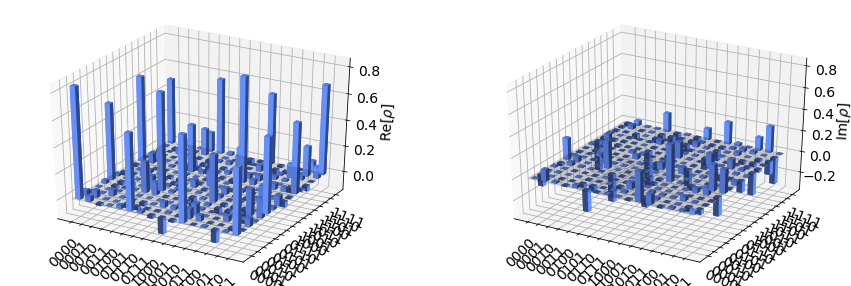

In [60]:
q.tools.visualization.plot_state_city(choi_lstsq.data)

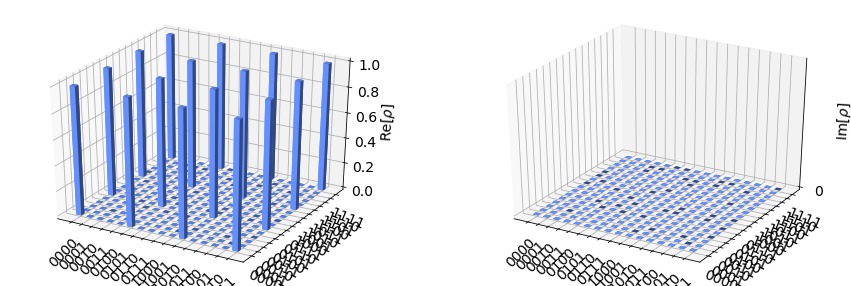

In [61]:
qreg = q.QuantumRegister(2)
circ = q.QuantumCircuit(qreg)

job = qiskit.execute(circ, q.Aer.get_backend('unitary_simulator'))
ideal_unitary = job.result().get_unitary(circ)
choi_ideal = q.tools.qi.qi.outer(ideal_unitary.ravel(order='F'))

q.tools.visualization.plot_state_city(choi_ideal)

In [62]:
print('fit fidelity (process):',
      np.real(q.quantum_info.process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))

fit fidelity (process): 0.3549193837897329
